In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/twitter-airline-sentiment/Tweets.csv
/kaggle/input/twitter-airline-sentiment/database.sqlite


## IMPORT LIBRARIES AND LOAD DATA

In [2]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import colormaps
import matplotlib.pyplot as plt
import os


In [3]:
import nltk
import re
import string
import random
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
import pandas as pd
from nltk.tag import pos_tag
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import matplotlib as plt
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, auc, classification_report, f1_score
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


2024-08-15 07:50:01.165679: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-15 07:50:01.165818: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-15 07:50:01.291927: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
import tensorflow as tf
from collections import Counter
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [5]:
tweets_data = pd.read_csv('/kaggle/input/twitter-airline-sentiment/Tweets.csv')
tweets_data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


# EXPLORATORY DATA ANALYSIS

In [6]:
tweets_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [7]:
tweets_data.describe()

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,1.464000e+04,14640.000000,10522.000000,14640.000000
mean,5.692184e+17,0.900169,0.638298,0.082650
std,7.791112e+14,0.162830,0.330440,0.745778
min,5.675883e+17,0.335000,0.000000,0.000000
25%,5.685592e+17,0.692300,0.360600,0.000000
50%,5.694779e+17,1.000000,0.670600,0.000000
75%,5.698905e+17,1.000000,1.000000,0.000000
max,5.703106e+17,1.000000,1.000000,44.000000


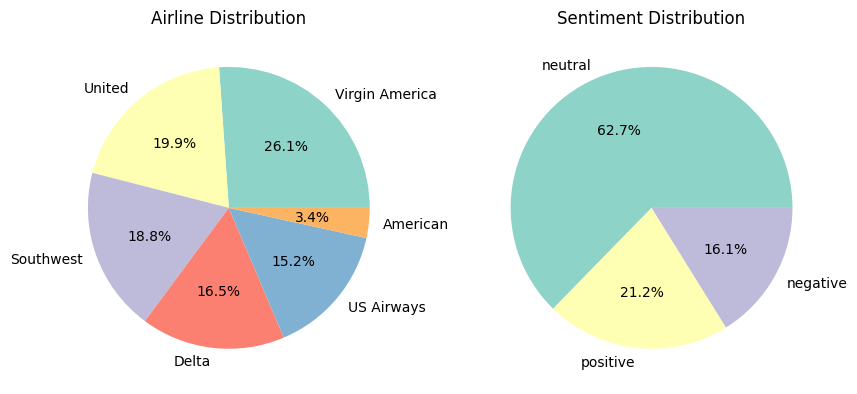

In [8]:

airlines = tweets_data['airline'].unique()
sentiments = tweets_data['airline_sentiment'].unique()

nrows, ncols = 1, 2
fig, ax = plt.subplots(nrows, ncols, figsize=(10, 8))

count_airlines = tweets_data['airline'].value_counts() #Series: counts by airlines
# top-left pie chart
ax[0].pie(count_airlines, labels=airlines, autopct='%1.1f%%', colors=plt.cm.Set3(range(len(airlines))))
ax[0].set_title("Airline Distribution")

# ---
count_sentiment = tweets_data['airline_sentiment'].value_counts() #Series: sentiment counts by airlines

# top-right
ax[1].pie(count_sentiment, labels=sentiments, autopct='%1.1f%%', colors=plt.cm.Set3(range(len(sentiments))))
ax[1].set_title("Sentiment Distribution")

# Show the plot
plt.show()

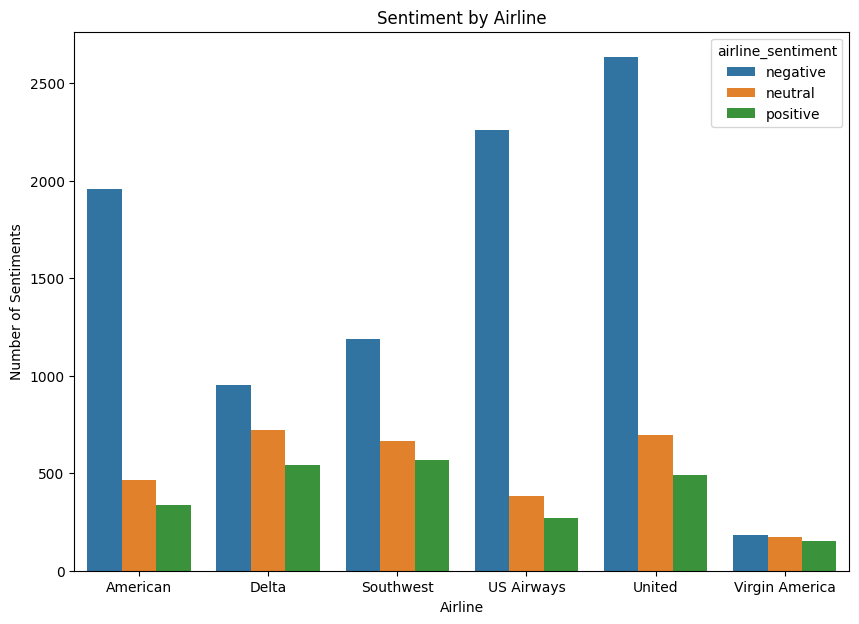

In [9]:

sentiment_by_airline = tweets_data.groupby(['airline', 'airline_sentiment']).size().reset_index(name='count')
plt.figure(figsize=(10, 7))
sns.barplot(x='airline', y='count', hue='airline_sentiment', data=sentiment_by_airline)
plt.title("Sentiment by Airline")
plt.xlabel("Airline")
plt.ylabel("Number of Sentiments")

plt.show()

# Prepocessing

In [10]:
#map sentiments to numerical values 'negative': 0, 'neutral':1,'positive':2
tweets_data['airline_sentiment'] = tweets_data['airline_sentiment'].apply(lambda x: 0 if x == 'negative' else 1 if x == 'neutral' else 2)
tweets_data['airline_sentiment'].value_counts()

airline_sentiment
0    9178
1    3099
2    2363
Name: count, dtype: int64

In [11]:
tweets_data['negative_text'] = tweets_data['negativereason'].fillna('') + ' ' + tweets_data['text'].fillna('')
tweets_data['negative_text'].head()

0                  @VirginAmerica What @dhepburn said.
1     @VirginAmerica plus you've added commercials ...
2     @VirginAmerica I didn't today... Must mean I ...
3    Bad Flight @VirginAmerica it's really aggressi...
4    Can't Tell @VirginAmerica and it's a really bi...
Name: negative_text, dtype: object

**Note:** 
Obviously, before diving into sentiment analysis, we need to complete some tasks like removing mentioned usernames, deal with English contractions (can't, 've,...),...

## Data preprocessing functions

In [12]:
def remove_username(text):
    return re.sub('@[^\s]+','',text)

def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

In [13]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [14]:
def replace_contraction(text):
    contractions = {
        r"won\'t": "will not",
        r"won\'t\'ve": "will not have",
        r"can\'t": "can not",
        r"can\'t\'ve": "can not have",
        r"ma\'am": "madam",
        r"let\'s": "let us",
        r"ain\'t": "am not",
        r"shan\'t": "shall not",
        r"sha\n\'t": "shall not",
        r"o\'clock": "of the clock",
        r"y\'all": "you all",
        r"n\'t": "not",
        r"n\'t\'ve": "not have",
        r"\'re": "are",
        r"\'s": "is",
        r"\'d": "would",
        r"\'d\'ve": "would have",
        r"\'ll": "will",
        r"\'ll\'ve": "will have",
        r"\'t": "not",
        r"\'ve": "have",
        r"\'m": "am"
    }

    for contraction, expansion in contractions.items():
        text = re.sub(contraction, expansion, text)

    return text

In [15]:
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    tokens = nltk.word_tokenize(text)
    text = ' '.join([word for word in tokens if word.lower() not in stop_words])
    return text

In [16]:
def remove_punctuation(text: str):
    return text.translate(str.maketrans("", "", string.punctuation))

## Apply preprocessing functions

In [17]:
tweets_data['negative_text'] = tweets_data['negative_text'].apply(lambda x: remove_username(x))
tweets_data['negative_text'] = tweets_data['negative_text'].apply(lambda x: remove_url(x))
tweets_data['negative_text'] = tweets_data['negative_text'].apply(lambda x: replace_contraction(x))
tweets_data['negative_text'] = tweets_data['negative_text'].apply(lambda x: x.lower())
tweets_data['negative_text'] = tweets_data['negative_text'].apply(lambda x: remove_stopwords(x))
tweets_data['negative_text'] = tweets_data['negative_text'].apply(lambda x: remove_punctuation(x))

In [18]:
tweets_data['negative_text'].head()

0                                                said 
1    plus youhave added commercials experience  tacky 
2      didnot today  must mean need take another trip 
3    bad flight itis really aggressive blast obnoxi...
4                 canot tell itis really big bad thing
Name: negative_text, dtype: object

# Sentiment Analysis

## Split data into training and testing set

In [20]:
from sklearn.model_selection import train_test_split
transformed_data = tweets_data[['negative_text', 'airline_sentiment']].copy()

test_size = 0.2
transformed_data_train, transformed_data_test = train_test_split(transformed_data, test_size=test_size, random_state=42)

print("Total: ", len(transformed_data))
print("Training samples: ", len(transformed_data_train))
print("Testing samples: ", len(transformed_data_test))

Total:  14640
Training samples:  11712
Testing samples:  2928


In [21]:
transformed_data.head()

,negative_text,airline_sentiment
0,said,1
1,plus youhave added commercials experience tacky,2
2,didnot today must mean need take another trip,1
3,bad flight itis really aggressive blast obnoxi...,0
4,canot tell itis really big bad thing,0


In [24]:
tokenized_data = transformed_data_train['negative_text'].apply(lambda x: x.split())
all_tokens = [token for sublist in tokenized_data for token in sublist]
# all_tokens

In [25]:
# Create a Counter of tokens and sort by frequency
count_token = Counter(all_tokens)
sorted_count_token = sorted(count_token.items(), key=lambda item: item[1], reverse=True)

In [26]:
import tensorflow as tf
from collections import Counter
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Create vocabulary mapping words to indices
vocab = {"<unk>": 0, "<pad>": 1, "<bos>": 2, "<eos>": 3}  # Special tokens
index = len(vocab)
for token, freq in sorted_count_token:
    if token not in vocab:
        vocab[token] = index
        index += 1

# Map words to indices and pad sequences
def preprocess_and_pad(text):
    tokens = text.split()
    indexed_tokens = [vocab.get(token, vocab['<unk>']) for token in tokens]
    return indexed_tokens

# Apply padding to sequences
max_seq_length = 100 
transformed_data_train['padded_negative_text'] = transformed_data_train['negative_text'].apply(preprocess_and_pad)
transformed_data_test['padded_negative_text'] = transformed_data_test['negative_text'].apply(preprocess_and_pad)

# Pad sequences to a fixed length
train_sequences = pad_sequences(transformed_data_train['padded_negative_text'], maxlen=max_seq_length, padding='post', truncating='post', value=vocab['<pad>'])
test_sequences = pad_sequences(transformed_data_test['padded_negative_text'], maxlen=max_seq_length, padding='post', truncating='post', value=vocab['<pad>'])

# Convert the padded sequences to TensorFlow tensors
padded_train_sequences = tf.constant(train_sequences)
padded_test_sequences = tf.constant(test_sequences)

# Example of the prepared input data
print("Padded Train Sequences Shape:", padded_train_sequences.shape)
print("Padded Test Sequences Shape:", padded_test_sequences.shape)

Padded Train Sequences Shape: (11712, 100)
Padded Test Sequences Shape: (2928, 100)


In [33]:
padded_train_sequences

<tf.Tensor: shape=(11712, 100), dtype=int32, numpy=
array([[ 12,  10, 867, ...,   1,   1,   1],
       [ 12,  10, 133, ...,   1,   1,   1],
       [161,  72, 226, ...,   1,   1,   1],
       ...,
       [  6,   5,   7, ...,   1,   1,   1],
       [  6,   5,   7, ...,   1,   1,   1],
       [113, 234, 145, ...,   1,   1,   1]], dtype=int32)>

In [27]:
import keras
from keras import ops
from keras import layers

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

In [28]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = ops.shape(x)[-1]
        positions = ops.arange(start=0, stop=maxlen, step=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [34]:
# Define constants
vocab_size = len(vocab)  # Vocabulary size: Only consider the top 20k words
maxlen = max_seq_length  # Maximum sequence length: Consider the first 200 words of each review

# Calculate the number of training samples (90% of the data)
num_train_samples = int(0.90 * len(padded_train_sequences))
num_val_samples = len(padded_train_sequences) - num_train_samples  # Remaining 10% for validation

# Split the data into training and validation sets
train_X = padded_train_sequences[:num_train_samples]
val_X = padded_train_sequences[num_train_samples:]

train_y = transformed_data_train['airline_sentiment'][:num_train_samples].values
val_y = transformed_data_train['airline_sentiment'][num_train_samples:].values

# Output the data split summary
print(f"Total data: {len(padded_train_sequences)}")
print(f"Training data: {len(train_X)}")
print(f"Validation data: {len(val_X)}")


Total data: 11712
Training data: 10540
Validation data: 1172


In [37]:
train_data = tf.data.Dataset.from_tensor_slices((train_X, train_y))
val_data = tf.data.Dataset.from_tensor_slices((val_X, val_y))
test_data = tf.data.Dataset.from_tensor_slices((padded_test_sequences, transformed_data_test['airline_sentiment'].values))

# Set up DataLoader
batch_size = 32
train_loader = train_data.batch(batch_size).shuffle(buffer_size=len(train_X))
val_loader = val_data.batch(batch_size)
test_loader = test_data.batch(batch_size)

In [38]:
embed_dim = 32  # Embedding size for each token
num_heads = 5  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = transformer_block(x)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(3, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [39]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_and_position… │ (None, 100, 32)   │    412,672 │ input_layer[0][0] │
│ (TokenAndPositionE… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_block   │ (None, 100, 32)   │     23,232 │ token_and_positi… │
│ (TransformerBlock)  │                   │            │ transformer_bloc… │
│                     │                   │            │ transformer_bloc… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ transformer_bloc… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32)        │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 20)        │        660 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 20)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 3)         │         63 │ dropout_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 436,627 (1.67 MB)

 Trainable params: 436,627 (1.67 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
from tensorflow.keras.callbacks import EarlyStopping ,ReduceLROnPlateau ,ModelCheckpoint


#callbacks

EarlyStop=EarlyStopping(patience=10,restore_best_weights=True)
Reduce_LR=ReduceLROnPlateau(monitor='val_accuracy',verbose=2,factor=0.5,min_lr=0.00001)
model_check=ModelCheckpoint('/model.keras',monitor='val_loss',verbose=1,save_best_only=True)
callback=[EarlyStop , Reduce_LR,model_check]

In [41]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [42]:
history = model.fit(
    train_loader, batch_size=32, epochs=100, validation_data=(val_loader),callbacks=callback)

Epoch 1/100
 11/330 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.4930 - loss: 1.1831   

I0000 00:00:1723709044.794011     208 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1723709044.824570     208 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


299/330 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.6769 - loss: 0.7374

W0000 00:00:1723709063.806657     208 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


330/330 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.6852 - loss: 0.7133
Epoch 1: val_loss improved from inf to 0.30072, saving model to /model.keras
330/330 ━━━━━━━━━━━━━━━━━━━━ 44s 66ms/step - accuracy: 0.6855 - loss: 0.7126 - val_accuracy: 0.8217 - val_loss: 0.3007 - learning_rate: 0.0010
Epoch 2/100
329/330 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8481 - loss: 0.2798
Epoch 2: val_loss improved from 0.30072 to 0.21482, saving model to /model.keras
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8482 - loss: 0.2797 - val_accuracy: 0.9138 - val_loss: 0.2148 - learning_rate: 0.0010
Epoch 3/100
329/330 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9306 - loss: 0.1824
Epoch 3: val_loss improved from 0.21482 to 0.18279, saving model to /model.keras
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9306 - loss: 0.1824 - val_accuracy: 0.9360 - val_loss: 0.1828 - learning_rate: 0.0010
Epoch 4/100
324/330 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9550 - loss: 0.1273

In [43]:
loss , accuracy = model.evaluate(test_loader)
print('loss of test : ',loss)
print('accuracy of test  : ',accuracy)

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9218 - loss: 0.1977
loss of test :  0.1841573417186737
accuracy of test  :  0.931693971157074


In [48]:
#plotting training values
import seaborn as sns
sns.set()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

<Figure size 640x480 with 0 Axes>

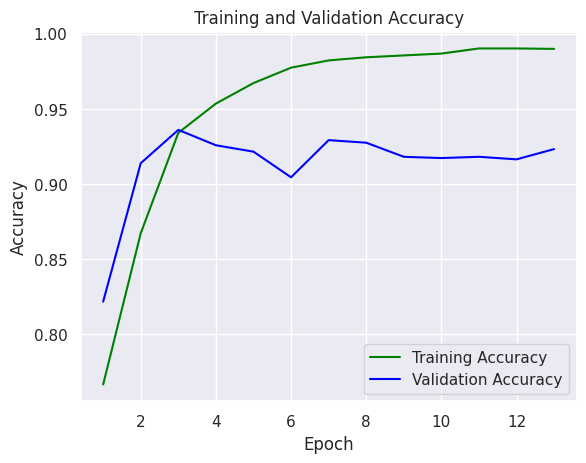

<Figure size 640x480 with 0 Axes>

In [47]:
#accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.figure()

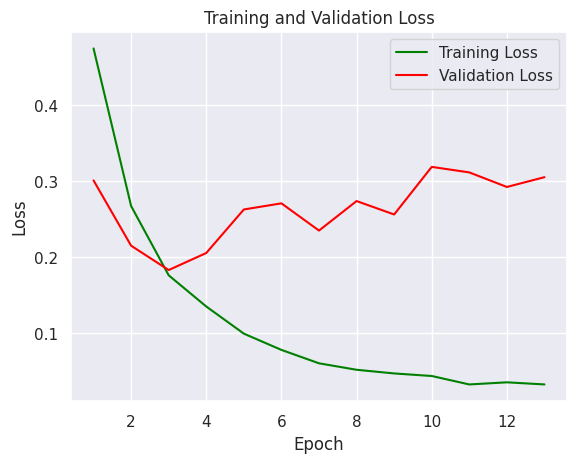

In [49]:
#loss plot
plt.plot(epochs, loss, color='green', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

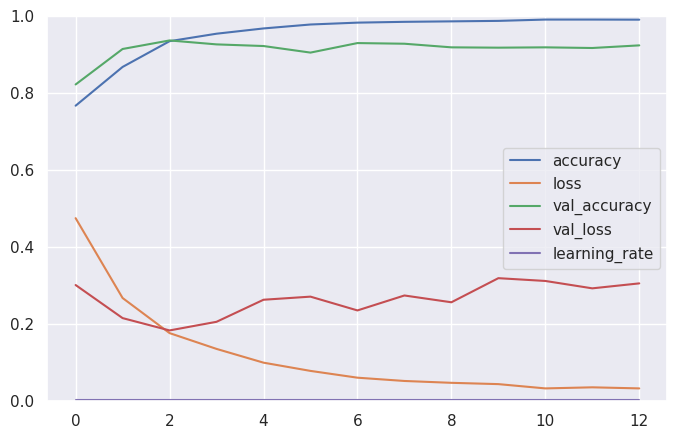

In [50]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [54]:
from sklearn.metrics import classification_report
predictions = model.predict(test_loader)
print(classification_report(transformed_data_test['airline_sentiment'], predictions.argmax(axis=-1)))

92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1889
           1       0.81      0.86      0.83       580
           2       0.81      0.74      0.78       459

    accuracy                           0.93      2928
   macro avg       0.87      0.87      0.87      2928
weighted avg       0.93      0.93      0.93      2928



<Axes: >

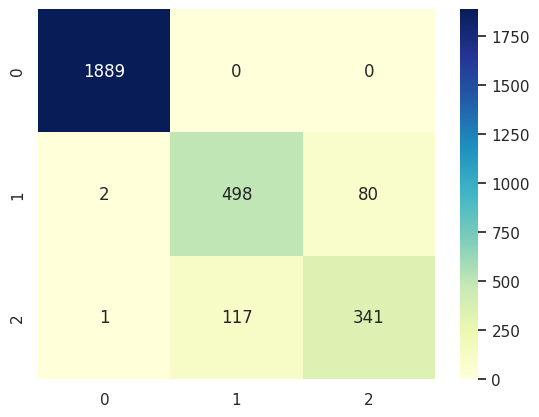

In [56]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(transformed_data_test['airline_sentiment'], predictions.argmax(axis=-1))

sns.heatmap(cm,  annot=True, fmt="d" ,cmap="YlGnBu")